In [2]:
import tensorflow as tf

ImportError: cannot import name 'enum_type_wrapper' from 'google.protobuf.internal' (unknown location)

In [1]:
import numpy as np

ImportError: cannot import name 'enum_type_wrapper' from 'google.protobuf.internal' (unknown location)

# Use to generate new data by manipulation

## What is this?
VAE stands for Variational Auto Encoder. Which means that is trained to reproduce or reconstruct from a latent space the input. Is an strategy to learn that latent space

It has 2 important blocks the Encoder wich will be responsable for condensing the data into a low dimensional latent space or just a vector.
And the Decoder by taking one point(how do you choose a point? By sampling) from the latent space is able to reconstruct a new image.

## How do VAEs build a latent space?
That is what difference a VAE from a AE that the V which means variational and allows the VAE to create continuous and structured latent spaces.

## How do you sample the latent space?


The latent space is structured, non sparse continuous and low dimentional where each direction encode a meanful axis of variation(V) of the data. And that means it can be manipulated with content vectors. Vectors that are isolated and represent a concept.
Like the concept of smile another image representation can be added to the smile concept vector then passed to the decoder to create a new image with the person smiling.

```There are concept vectors for any independent direction of the latent space```
```deeplearning with bayesian inference```

## Steps
- Build the encoder
    - The output will be 2 vectors mean and variance
- Build the sampler using a random small vector along with the 2 vectors the encoder will give us
    - normal dist value = mean * exp(std) * epsilon / epsilon is a random small vector from the latent space
- Build the loss
    - kubell-divergence
    - reconstruction loss mean already coded in keras
- Build the decoder
    - the decoder will take the sampled input and reconstruct it to a valid image!

# Encoder

The encoder will transform the image into 2 parameters vectors that will be used to form a normal distribution, mean_vector and standard_deviation_vector

In [7]:
import os

DATASET_BASE_PATH = "../../datasets"

DATASET_NAME = "art_images"

FULL_PATH = "".join([DATASET_BASE_PATH, os.sep, DATASET_NAME])

In [8]:
IMAGE_INPUT_SHAPE = (64, 64)
IMAGE_OUTPUT_SHAPE = (128, 128)
CHANNELS = 1

input_image = tf.keras.utils.image_dataset_from_directory(FULL_PATH,
                                                             label_mode=None,
                                                               image_size=IMAGE_INPUT_SHAPE,
                                                                 batch_size=256,
                                                                 shuffle=True,
                                                                 color_mode="grayscale",
                                                                 smart_resize=True)

output_image = tf.keras.utils.image_dataset_from_directory(FULL_PATH,
                                                             label_mode=None,
                                                               image_size=IMAGE_OUTPUT_SHAPE,
                                                                 batch_size=256,
                                                                 shuffle=True,
                                                                 color_mode="grayscale",
                                                                 smart_resize=True)

NameError: name 'tf' is not defined

In [34]:
whole_dataset

<_BatchDataset element_spec=TensorSpec(shape=(None, 64, 64, 1), dtype=tf.float32, name=None)>

In [35]:
i = 0
for batch in whole_dataset:
    for image in batch:
        i+=1

In [36]:
whole_dataset = whole_dataset.map(lambda x: x/255., num_parallel_calls=tf.data.AUTOTUNE)

In [37]:
LATENT_DIMS = 2
IMAGE_CHANNELS = 1
PROY_DIM = 16 #16
# the input is the output of the sample(encoder(image))
# CHANNELS_ENCODER_OUTPUT = 256
CONVS_NUMBER_ENCODER = 5

In [38]:
# I need to use a fix size.. This should not be a limitation in the future.
# If I create a class I can surpass that limitation
X_input_encoder = tf.keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS))
filters_decoder = 16

# add more convs
#Last conv
X = tf.keras.layers.Conv2D(filters=filters_decoder, kernel_size=3, activation="relu", strides=2, padding="same")(X_input_encoder)

for channel_index in range(CONVS_NUMBER_ENCODER-1):
    filters_decoder *= 2
    X = tf.keras.layers.Conv2D(filters=filters_decoder, kernel_size=3, activation="relu", strides=2, padding="same")(X)
    CHANNELS_ENCODER_OUTPUT = filters_decoder
    #Adding more convs diminish kl divergence at first then increases it??

X = tf.keras.layers.Flatten()(X)

# Try a proyection model sequence latter
X = tf.keras.layers.Dense(units=PROY_DIM, activation="relu")(X)
# X = tf.keras.Sequential([tf.keras.layers.Dense(units=PROY_DIM, activation="relu"), tf.keras.layers.Dense(units=PROY_DIM)])(X)

z_mean = tf.keras.layers.Dense(units=LATENT_DIMS, name="z_mean")(X)
z_log_var = tf.keras.layers.Dense(units=LATENT_DIMS, name="z_log_var")(X)

encoder = tf.keras.Model(inputs=X_input_encoder, outputs=[z_mean, z_log_var])

In [39]:
encoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 16)   160         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 16, 16, 32)   4640        ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 8, 8, 64)     18496       ['conv2d_1[0][0]']               
                                                                                              

# Sampler!

We are sampling from a normal distribution

normal = mu + exp(sigma) * epsilon

epsilon is a random number from a normal distribution

In [40]:
class Sampler(tf.keras.layers.Layer):
    def call(self, z_mean, z_sigma):
        # get the batch size
        batch_size = tf.shape(z_mean)[0]
        latent_dim = tf.shape(z_mean)[1]

        #Epsilon should be the same size as our vectors
        # here we are in the training and everything gets processed in batch
        epsilon = tf.random.normal(shape=(batch_size, latent_dim))

        #This returns a sample point from the distribution we are trying to find.
        # A normal distribution
        # Why over 2? is that 2 the N elements?
        return z_mean + tf.math.exp(z_sigma/2) * epsilon

# Decoder

In [41]:
import math

In [42]:
#Image is 256 but we have 2 transpose layers the image will get upscaled 2 times and we only applied 1 layer of convs with strides 2 
# At this point the image is 128 but if we are going to upscale 2 times for the image to be again 256 it should be 64
CONVS_NUMBER = 3
IMAGE_HEIGHT_DECODE = IMAGE_WIDTH_DECODE = math.ceil(IMAGE_HEIGHT/(2**CONVS_NUMBER))

X_input_decoder = tf.keras.Input(shape=(LATENT_DIMS,))

X = tf.keras.layers.Dense(units=IMAGE_HEIGHT_DECODE * IMAGE_WIDTH_DECODE * CHANNELS_ENCODER_OUTPUT)(X_input_decoder)
X = tf.keras.layers.Reshape((IMAGE_HEIGHT_DECODE, IMAGE_WIDTH_DECODE, CHANNELS_ENCODER_OUTPUT))(X)

filters = CHANNELS_ENCODER_OUTPUT
for channel_index in range(CONVS_NUMBER):
    X = tf.keras.layers.Conv2DTranspose(filters, 3, activation="relu", strides=2, padding="same")(X)
    filters = math.ceil(filters/2)

X_decoder_output = tf.keras.layers.Conv2D(IMAGE_CHANNELS, 3, activation="sigmoid", padding="same")(X)

#X_input_decoder latent input
decoder = tf.keras.Model(X_input_decoder, X_decoder_output, name="decoder")

In [43]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 16384)             49152     
                                                                 
 reshape (Reshape)           (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 256)      590080    
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 128)      295040    
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 64, 64, 64)       7379

In [44]:
sample = tf.constant(np.random.normal(size=(8, 5, 4, 1)))

In [45]:
sample.shape

TensorShape([8, 5, 4, 1])

In [46]:
tf.reduce_sum(sample, axis=(1, 2))

<tf.Tensor: shape=(8, 1), dtype=float64, numpy=
array([[-9.24349543],
       [-6.53157088],
       [-2.33653475],
       [ 2.01187244],
       [ 3.40247619],
       [ 0.09401621],
       [-4.24325604],
       [-1.22383544]])>

In [47]:
tf.reduce_mean(tf.reduce_sum(sample, axis=(1, 2)))

<tf.Tensor: shape=(), dtype=float64, numpy=-2.2587909613984563>

In [48]:
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, sampler, **kwars):
        """ 
         It has 3 main blocks 
            - encoder
            - decoder
            - sampler
        """
        super().__init__(**kwars)
        self.encoder = encoder
        self.decoder = decoder
        self.sampler = sampler

        # sum all losses
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_flat_loss")

        # how close the reconstructed sample by the decoder is to the original source
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")

        # divergence from the distribution created to model the latent space and the real one which is a normal distribution
        # From where the epsilon point comes from?
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    def call(self, inputs):
        z_mean, z_sigma = self.encoder(inputs)
        return self.decoder(self.sampler(z_mean, z_sigma))

    @property
    def metrics(self):
        return [self.total_loss_tracker,
                self.reconstruction_loss_tracker,
                self.kl_loss_tracker]
    
    def train_step(self, batch_data):
        with tf.GradientTape() as tape:
            z_mean, z_sigma = self.encoder(batch_data)
            sampled_point_z = self.sampler(z_mean, z_sigma)
            reconstructed_data = self.decoder(sampled_point_z)

            reconstruction_loss = tf.reduce_mean(
                # The image needs to be normalized between 0 and 1 for this to make sense
                # binary difference between input data and reconstructed
                tf.reduce_sum(tf.keras.losses.binary_crossentropy(batch_data, reconstructed_data),
                              # sum by sample, reduce the whole row to 1 value
                              axis=(1, 2))
            )

            kl_loss = -0.5 * (1 + z_sigma - tf.math.square(z_mean) - tf.math.exp(z_sigma))

            # this adds all 2 losses into one
            # how well the input was reconstructed and the distribution difference to create the latent space
            total_loss = reconstruction_loss + tf.reduce_mean(kl_loss)

        # Standard way to propagate the error signal?
        gradients = tape.gradient(total_loss, self.trainable_weights)
        # gradients = tape.gradient(total_loss, [z_mean, z_sigma])
        self.optimizer.apply_gradients(zip(gradients, self.trainable_weights))
        # self.optimizer.apply_gradients(zip(gradients, [z_mean, z_sigma]))

        # add and average the loss so far up to this batch
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "total_loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result()
        }


In [49]:
tf.keras.backend.clear_session()

In [50]:
vae = VAE(encoder=encoder, decoder=decoder, sampler=Sampler())

In [51]:
vae.compile(optimizer=tf.keras.optimizers.legacy.Adam(), run_eagerly=None)

# TODO: add a callback to preview the output of the generator vs the original image

In [52]:
vae.fit(whole_dataset, epochs=300)

Epoch 1/300
69/69 [==============================] - 13s 178ms/step - total_loss: 2820.9522 - reconstruction_loss: 2804.4683 - kl_loss: 0.7071
Epoch 2/300
69/69 [==============================] - 13s 187ms/step - total_loss: 2705.9117 - reconstruction_loss: 2685.4678 - kl_loss: 3.3997
Epoch 3/300
69/69 [==============================] - 13s 191ms/step - total_loss: 2675.6457 - reconstruction_loss: 2670.2405 - kl_loss: 2.9907
Epoch 4/300
69/69 [==============================] - 13s 190ms/step - total_loss: 2673.0759 - reconstruction_loss: 2669.2046 - kl_loss: 2.9376
Epoch 5/300
69/69 [==============================] - 14s 193ms/step - total_loss: 2672.3383 - reconstruction_loss: 2668.8513 - kl_loss: 2.9250
Epoch 6/300
69/69 [==============================] - 14s 192ms/step - total_loss: 2673.1755 - reconstruction_loss: 2668.1179 - kl_loss: 2.8909
Epoch 7/300
69/69 [==============================] - 13s 189ms/step - total_loss: 2671.4102 - reconstruction_loss: 2668.2061 - kl_loss: 2.8986

In [53]:
sample = next(iter(whole_dataset))[0]
sample = np.expand_dims(sample, axis=0)

In [54]:
reconstructed = vae.predict(sample)

1/1 [==============================] - 0s 296ms/step


In [55]:
import matplotlib.pyplot as plt

In [56]:
reconstructed[0].shape
reconstructed = reconstructed[0]

In [57]:
reconstructed *= 128
reconstructed += 64
reconstructed = np.clip(0, 255, reconstructed)
reconstructed = reconstructed.astype("uint8")

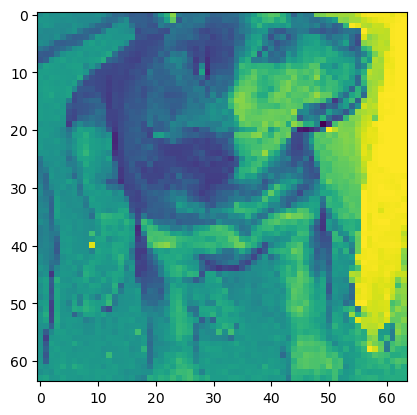

In [58]:
plt.imshow(sample[0])

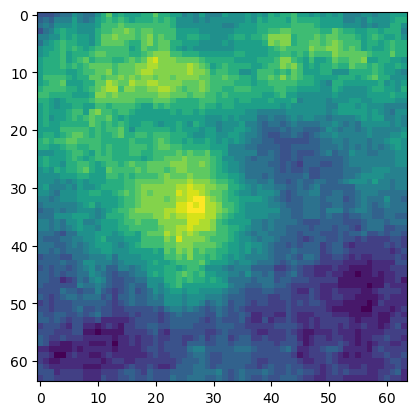

In [59]:
plt.imshow(reconstructed)

In [60]:
m, s = encoder(sample)